# Reliability analysis using OpenTURNS

This notebook presents the main steps of the uncertainty quantification framework. 

The analytical case of the flooding model illustrates the tools offered by OpenTURNS to perform a typical reliability analysis study.  

## 2. Analytical case: flooding model

The following figure presents a dyke protecting industrial facilities. When the river level exceeds the dyke height, flooding occurs. 
The model is based on a crude simplification of the 1D hydrodynamical equations of Saint-Venant under the assumptions of uniform and constant flow rate and large rectangular sections.

<img src="figures/flooding_section.png"  width=300>


The Following inputs are considered as independent random variables: 


 * $Q$ : Maximal annual flow [$m^3 s^{-1}$], &nbsp;&nbsp;        Gumbel(mode=1330, scale=500), Q > 0
 * $K_s$ : Strickler coefficient [$m^{1/3} s^{-1}$], &nbsp;&nbsp;               Lognormal($\mu_F=30.0, \sigma_F=7.5$), $K_s$ > 0
 * $B$ : River width [$m$], &nbsp;&nbsp;        Lognormal($\mu_F=200.0, \sigma_F=10.0$)
 * $\alpha$ : River slope [deg.], &nbsp;&nbsp; Normal($\mu = 10^{-3}, \sigma = 10^{-4}$).


The water level is determined by a simplified 1-dimensional hydraulic model:

$$
Y  = \left(\frac{Q}{K_s \cdot B \cdot \sqrt{\alpha}} \right)^{\frac35}
$$

In [1]:
import numpy as np
import pandas as pd
import openturns as ot
import copulogram as cp
import matplotlib.pyplot as plt
import openturns.viewer as viewer

### [Step A]: model definition

Function in OpenTURNS can be defined either using `ot.SymbolicFunction` when the function is explicit, otherwise it can be done using `ot.PythonFunction`

In [2]:
water_height_function = ot.SymbolicFunction(['Q', 'Ks', 'B', 'Alpha'], ['(Q / (Ks * B * sqrt(Alpha)))^(3/5)'])
# Testing the function
x_test = [1330, 30, 200, 0.001]
print(f"Water height({x_test}) = {water_height_function(x_test)}")

Water height([1330, 30, 200, 0.001]) = [3.21677]


### [Step B]: uncertainty model definition

See the large catalogue of marginals and copulas available in OpenTURNS: 

http://openturns.github.io/openturns/latest/user_manual/probabilistic_modelling.html

In [3]:
Q = ot.Gumbel(1330, 500)
Q = ot.TruncatedDistribution(Q, 0., ot.TruncatedDistribution.LOWER)
Ks = ot.LogNormalMuSigma(30, 7.5).getDistribution()
Ks = ot.TruncatedDistribution(Ks, 0., ot.TruncatedDistribution.LOWER)
B = ot.LogNormalMuSigma(200, 10).getDistribution()
Alpha = ot.Normal(1e-3, 1e-4)
marginals = [Q, Ks, B, Alpha]
joint_distribution = ot.ComposedDistribution(marginals)
joint_distribution.setDescription(['Q', 'Ks', 'B', 'Alpha'])
dim = joint_distribution.getDimension()
joint_distribution

Index,Variable,Distribution
0,Q,"TruncatedDistribution(Gumbel(beta = 1330, gamma = 500), bounds = [0, (43374.1) +inf[)"
1,Ks,"TruncatedDistribution(LogNormal(muLog = 3.37089, sigmaLog = 0.246221, gamma = 0), bounds = [0, (191.45) +inf[)"
2,B,"LogNormal(muLog = 5.29707, sigmaLog = 0.0499688, gamma = 0)"
3,Alpha,"Normal(mu = 0.001, sigma = 0.0001)"


### [Step C]: uncertainty propagation

#### Monte Carlo propagation

In [4]:
size = 1000
x_MC_sample = joint_distribution.getSample(size)
y_MC_sample = water_height_function(x_MC_sample)

Other sampling methods available.

**For mean estimation:** 
- 1D Deterministic quadratures (Gauss-Legendre, Gauss-Legendre, Féjer)
- multi-D Deterministic quadratures (regular, sparse grids)
- Quasi-Monte Carlo, Randomized Quasi-Monte Carlo 
- Latin Hypercube Sampling
- Optimal Latin Hypercube Sampling

**For rare event estimation:**
- FORM/SORM
- Importance Sampling
- Line Sampling
- Subset Sampling
- Cross-entropy Importance Sampling
- Non-Adaptive Importance Sampling
  
This notebook illustrates all rare event estimation (reliability analysis) methods on this case. 

#### Data visualization


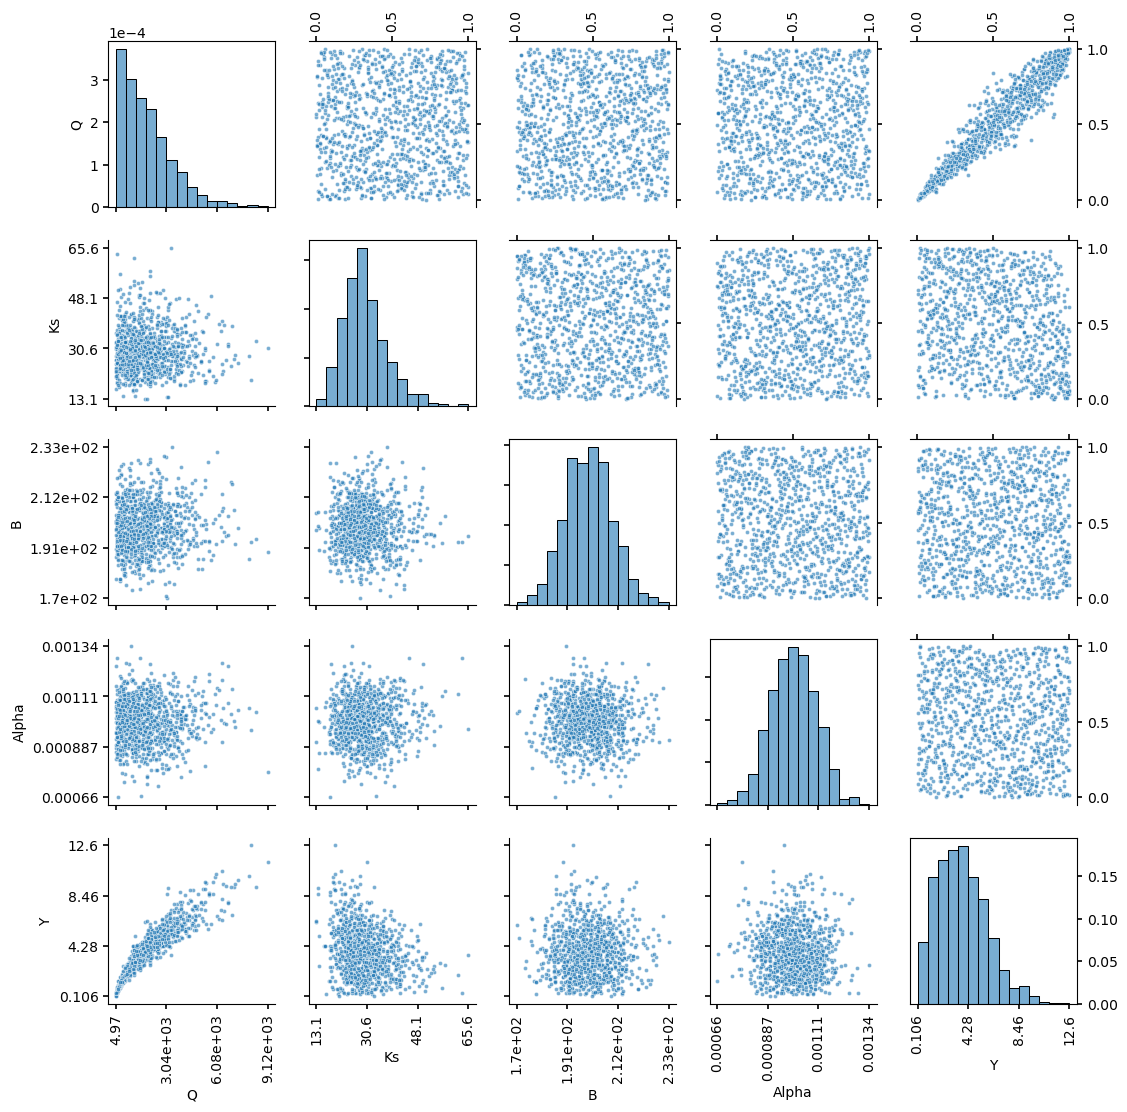

In [5]:
data = pd.DataFrame(np.array(x_MC_sample), columns=list(joint_distribution.getDescription()))
data['Y'] = np.array(y_MC_sample)
copulogram = cp.Copulogram(data)
copulogram.draw(alpha=0.6, marker='.');

In [6]:
threshold = 10

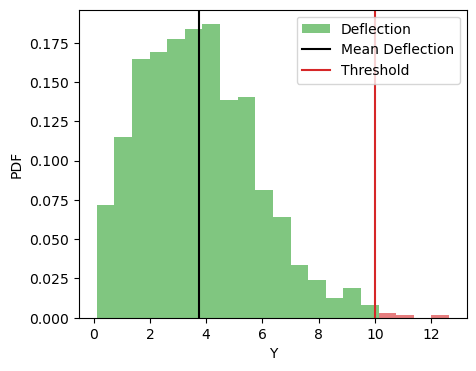

In [7]:
fig, ax = plt.subplots(figsize=(5, 4))
N, bins, patches = ax.hist(data['Y'], bins=20, density=True, alpha=0.6, color='C2', label="Deflection")
for i in range(16, 20):
    patches[i].set_facecolor('C3')
plt.axvline(data['Y'].mean(), color='k', label="Mean Deflection")
plt.axvline(threshold, color='C3', label="Threshold")
plt.xlabel("Y")
plt.ylabel("PDF")
plt.legend();

In [8]:
data['is_failed'] = 0
data.loc[data[data['Y'] > threshold].index, 'is_failed'] = 1
data

,Q,Ks,B,Alpha,Y,is_failed
0,1526.347172,36.897392,201.748419,0.000951,3.116191,0
1,3269.379139,22.272112,204.536370,0.000845,6.847486,0
2,424.679651,28.192431,201.555539,0.001062,1.645546,0
3,5117.787871,25.801641,200.487662,0.001016,7.855445,0
4,3815.986344,24.717852,208.143790,0.001050,6.543572,0
...,...,...,...,...,...,...
995,1887.095746,25.972112,204.156909,0.001013,4.257681,0
996,343.853391,36.873665,201.645003,0.001001,1.255818,0
997,3684.838397,27.931058,208.413141,0.000917,6.197116,0
998,1446.934506,45.198223,197.822145,0.001290,2.467557,0


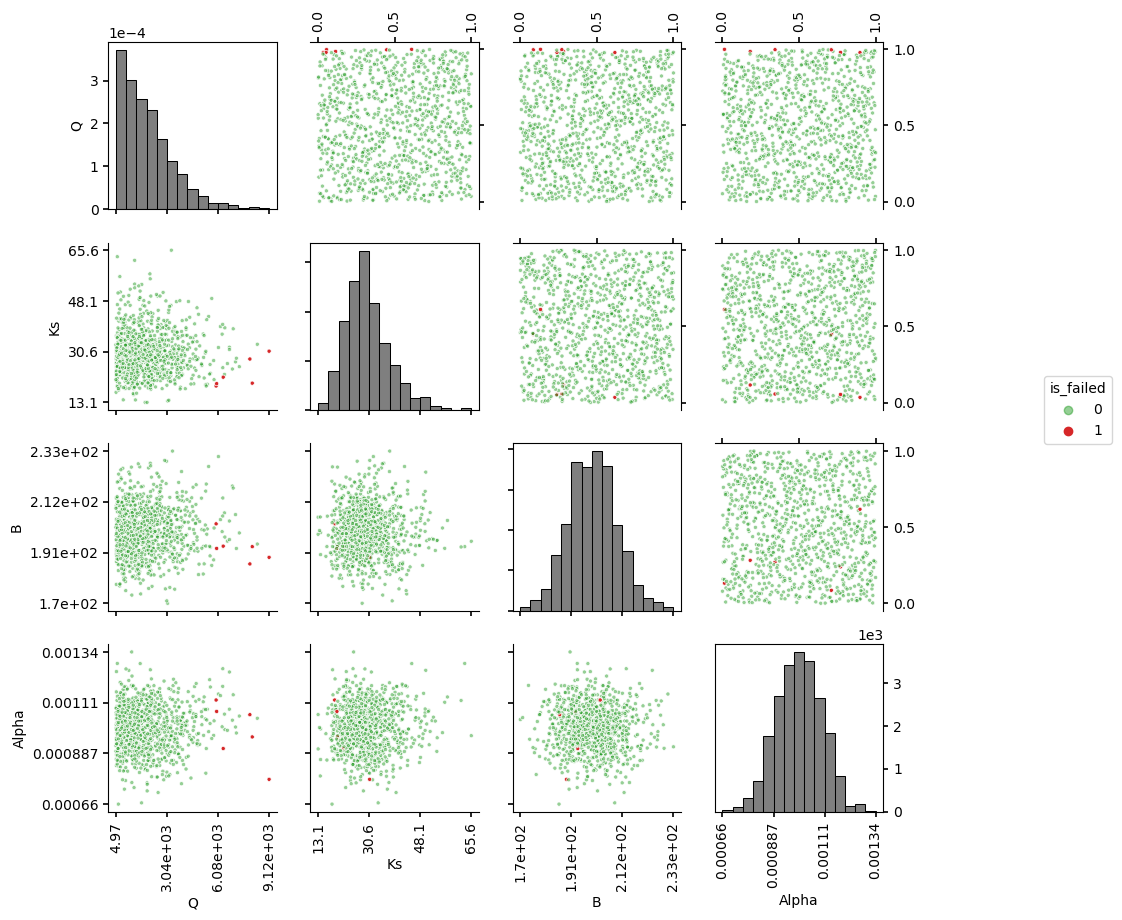

In [9]:
import seaborn as sns
from matplotlib.colors import to_rgba
# Define tailored binary colorbar
my_palette = sns.color_palette([to_rgba('C2', 0.5), to_rgba('C3', 1.)], as_cmap=True)

copulogram = cp.Copulogram(data[['Q', 'Ks', 'B', 'Alpha', 'is_failed']])
copulogram.draw(hue='is_failed', hue_colorbar=my_palette, marker='.', kde_on_marginals=False);

In [10]:
# Monte Carlo failure probability 
MC_pf = data['is_failed'].mean()
print(f"Monte Carlo pf: {MC_pf}")

Monte Carlo pf: 0.006


## OpenTURNS reliability analysis methods

See the following API page regarding the methods used below: 

https://openturns.github.io/openturns/latest/user_manual/threshold_probability_simulation_algorithms.html

### Define a generic `ThresholdEvent`

The `ThresholdEvent` object gathers all the inputs needed for a reliability problem

In [11]:
threshold = 10.0
X = ot.RandomVector(joint_distribution)
Y = ot.CompositeRandomVector(water_height_function, X)
failure_event = ot.ThresholdEvent(Y, ot.GreaterOrEqual(), threshold)

### FORM / SORM

In [12]:
# Many other optimization algorithms (i.e., solvers) available.
# See: https://openturns.github.io/openturns/latest/user_manual/optimization.html
# Cobyla is a gradient-free solver. 
solver = ot.Cobyla()
starting_point = joint_distribution.getMean()
# See FORM API: https://openturns.github.io/openturns/latest/user_manual/_generated/openturns.FORM.html
FORM_algo = ot.FORM(solver, failure_event, starting_point)
FORM_algo.run()
FORM_result = FORM_algo.getResult()
beta = FORM_result.getHasoferReliabilityIndex()
importance_factors = FORM_result.getImportanceFactors()
u_star = FORM_result.getStandardSpaceDesignPoint()
FORM_pf = FORM_result.getEventProbability()
print(f"FORM pf: {FORM_pf:.2e}")

FORM pf: 7.46e-03


In [13]:
# See SORM API: https://openturns.github.io/openturns/latest/user_manual/_generated/openturns.SORM.html
SORM_algo = ot.SORM(solver, failure_event, starting_point)
SORM_algo.run()
SORM_result = SORM_algo.getResult()
beta = SORM_result.getHasoferReliabilityIndex()
importance_factors = SORM_result.getImportanceFactors()
u_star = SORM_result.getStandardSpaceDesignPoint()
SORM_pf = SORM_result.getEventProbabilityBreitung()
print(f"SORM pf: {SORM_pf:.2e}")

SORM pf: 7.26e-03


### Importance Sampling / Quasi-Monte Carlo / LHS

In [14]:
# Set random seed to exactly repeat results 
#ot.RandomGenerator.SetSeed(0)

In [15]:
# Define an experiment (i.e., a sampling method among MC, IS, QMC, LHS)

## Monte Carlo 
mc_experiment = ot.MonteCarloExperiment()

## FORM - Importance sampling
importance_density = ot.Normal(u_star, [1.0] * dim) # Standard Gaussian centered around the FORM design point
is_experiment = ot.ImportanceSamplingExperiment(importance_density)

# Quasi-Monte Carlo
qmc_experiment = ot.LowDiscrepancyExperiment()
#qmc_experiment.setRandomize(True) # Randomized option

# LHS
lhs_experiment = ot.LHSExperiment()
#lhs_experiment.setAlwaysShuffle(True) # Randomized option

In [16]:
standard_event = ot.StandardEvent(failure_event)
algo = ot.ProbabilitySimulationAlgorithm(standard_event, is_experiment) # The user can change the experiment with one defined above 
# Algorithm stopping criterions
algo.setMaximumOuterSampling(int(1e3))
algo.setBlockSize(1)
algo.setMaximumCoefficientOfVariation(0.05)
# Perform the simulation
algo.run()
simulation_results = algo.getResult()
simulation_pf = simulation_results.getProbabilityEstimate()
print(f'FORM-IS failure probability = {simulation_pf:.2e}')

FORM-IS failure probability = 6.96e-03


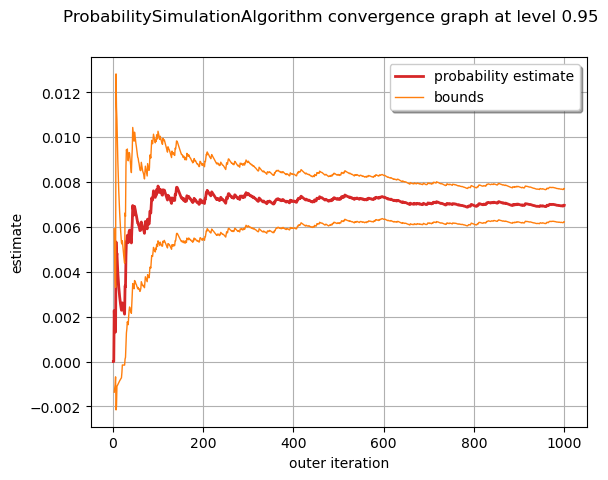

In [17]:
palette = ot.Drawable.BuildDefaultPalette(10)
graph = algo.drawProbabilityConvergence(0.95)
graph.setColors([palette[3], palette[1], palette[1]])
view = viewer.View(graph)

### Subset sampling

In [18]:
SS_algo = ot.SubsetSampling(failure_event)
SS_algo.setMaximumOuterSampling(int(1e4))
SS_algo.setBlockSize(1)
SS_algo.run()
SS_results = SS_algo.getResult()
levels = SS_algo.getThresholdPerStep()
SS_pf = SS_results.getProbabilityEstimate()
print(f'Subset sampling failure probability = {SS_pf:.2e}')

Subset sampling failure probability = 7.34e-03


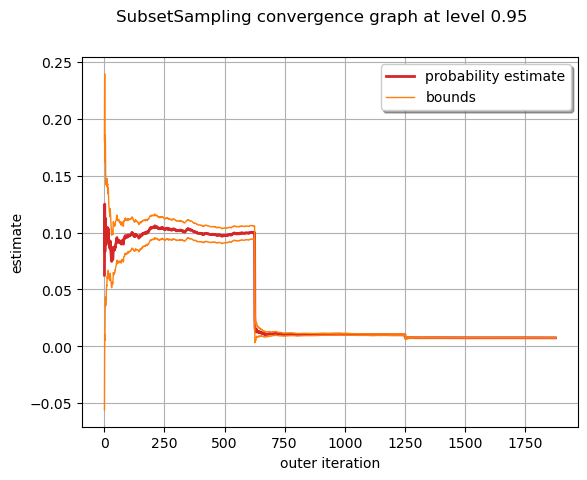

In [19]:
graph = SS_algo.drawProbabilityConvergence(0.95)
graph.setColors([palette[3], palette[1], palette[1]])
view = viewer.View(graph)